In [2]:
import os
import cv2
import numpy as np

# 1. Preprocess silhouettes (đã test xong) chạy oke
# chuyển ảnh silhoute thành ảnh nhị phân trắng đen
def preprocess_silhouettes(folder_path):
    silhouettes = []
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_paths:
        raise ValueError("No valid image files found in the folder.")
    
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"⚠️ Warning: Cannot read image at {path}")
            break
        
        _, binary = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)
        silhouettes.append(binary)
        
    if not silhouettes:
        raise ValueError("No Valid images were processed. Check file paths")
    
    return np.array(silhouettes)


In [3]:
# 2. Compute Gait Energy Image (GEI) (chạy oke)
# sử dụng ảnh silhoute trắng đen trước đó để tính ảnh GEI
def compute_gei(silhouettes):
    return np.mean(silhouettes, axis=0)

def show_image(image, title="Image", scale=7):
    h, w = image.shape
    resized_image = cv2.resize(image, (w * scale, h * scale), interpolation=cv2.INTER_NEAREST)
    cv2.imshow(title, resized_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [4]:
# lưu ảnh vào thư mục đã chọn
def save_image(image, folder_path, image_name):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    save_path = os.path.join(folder_path, image_name)
    cv2.imwrite(save_path, image)
    # print(f"✅ Image saved at {save_path}")

In [5]:
root_folder = "data"
gei_path = "GEI"

# tạo thư mục chứa data ảnh GEI, nếu chưa có thư mục đóđó
if not os.path.exists(gei_path):
    os.makedirs(gei_path)  

def gei_img_process(root_folder):
    labels = []
    for object in os.listdir(root_folder):
        if not os.path.exists(f"{gei_path}/{object}"):
            os.makedirs(f"{gei_path}/{object}")
        for folder in os.listdir(f"{root_folder}/{object}"):
            a = 0
            if not os.path.exists(f"{gei_path}/{object}/{folder}"):
                os.makedirs(f"{gei_path}/{object}/{folder}")
            for direction in os.listdir(f"{root_folder}/{object}/{folder}"):
                # binary_imgs = preprocess_silhouettes(f"{root_folder}/{object}/{folder}/{direction}")
                # gei = compute_gei(binary_imgs)
                # save_image((gei*255).astype(np.uint8),f"{gei_path}/{object}/{folder}", f"{direction}.jpg")
                a += 1
        labels.append(a)
    print(labels)
    return labels

In [6]:
# nếu trên máy tính bạn chưa có folder GEI thì gỡ comment và chạy câu lệnh dưới
token = gei_img_process(root_folder)

[11, 11, 11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [7]:
# load data
# gallery = nm-03, nm-04, nm-05, nm-6
# probe = bg-01, bg-02, cl-01, cl-02, nm-01, nm-02
data_path = "GEI"
def load_data(folder_paths):
    gallery, probe = [], []
    prob = ["bg-01", "bg-02", "cl-01", "cl-02", "nm-01", "nm-02"]
    for object in os.listdir(folder_paths):
        for type in os.listdir(f"{folder_paths}/{object}"):
            for dir in os.listdir(f"{folder_paths}/{object}/{type}"):
                img = cv2.imread(f"{folder_paths}/{object}/{type}/{dir}", cv2.IMREAD_GRAYSCALE)
                if(type in prob):
                    probe.append(img)
                else:
                    gallery.append(img)
    
    return gallery, probe
                
real_gallery, real_probe = load_data(data_path)

In [8]:
# FUN FACT: đối tượng thứ 005, không có góc quay nhận dạng chính diện
len(real_gallery), len(real_probe)

(876, 1314)

In [9]:
import math

# 3. Generate synthetic GEI templates (oke)
# tạo ra 8 bức ảnh synthetic với mỗi ảnh GEI
def synthetic_templates(real_imgs, iter = 4, k = 2):
    x, y = real_imgs[0].shape
    synthetic_templates = []
    h = 2, max(x, y)
    
    for img in real_imgs:
        for i in range(1,1+iter):
            temp = np.copy(img)
            # remove k*i rows from the bottoms of the original img
            cut_bot = temp[0:x-i*k, 0:y]
            d = math.floor(x*y/(x-i*k))
            # resize the remaining template
            cut_bot = cv2.resize(cut_bot, (d, x))
            # equally cut left and right borders to generate a x*y size synthetic template
            cut_bot = cut_bot[:,i:d-i]
            
            cut_top = temp[i*k:x, 0:y]
            cut_top = cv2.resize(cut_top, (d, x))
            cut_top = cut_top[:,i:d-i]
            if cut_bot.shape[1] == 65: 
                cut_bot = cut_bot[:,1:65]
            if cut_top.shape[1] == 65:
                cut_top = cut_top[:, 1:65]
                
            synthetic_templates.append(cut_bot)
            synthetic_templates.append(cut_top)
    
    return synthetic_templates

In [10]:
synthetic_gallery = synthetic_templates(real_gallery)
synthetic_probe = synthetic_templates(real_probe)

# create eight synthetic templates from each GEI input
print(f"galler: {len(real_gallery)}, {len(synthetic_gallery)}")
print(f"probe: {len(real_probe)}, {len(synthetic_probe)}")

for i in synthetic_gallery[0:10]:
    show_image(i)

galler: 876, 7008
probe: 1314, 10512


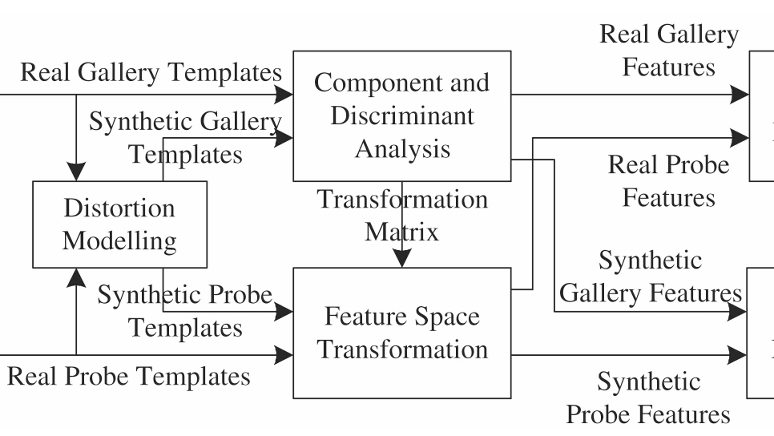

In [11]:
# tạo labels để đưa vào hàm MDA
def create_labels(gallery_imgs_per_object, probe_imgs_per_object, labels_token):
    real_labels, probe_labels = [], []
    gallery_size, probe_size = gallery_imgs_per_object ,probe_imgs_per_object
      
    for i, object in enumerate(labels_token):
        for _ in range(object*gallery_size):
            real_labels.append(i+1)
        
    for i, object in enumerate(labels_token):
        for _ in range(object*probe_size):
            probe_labels.append(i+1)
        
    print(len(real_labels))
    print(len(probe_labels))
    return real_labels, probe_labels

real_gallery_labels, real_probe_labels = create_labels(4, 6, token)
synthetic_gallery_labels, synthetic_probe_labels = create_labels(32, 48, token)
# print(synthetic_gallery_labels.count(1))

876
1314
7008
10512


In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as MDA

def pca_and_mda(real, synthetic, real_labels, synthetic_labels):
    real_in,  synth_in = [], []
    for r in real:
        real_in.append(r.flatten())
    for s in synthetic:
        synth_in.append(s.flatten())  
    # calculate PCA    
    pca = PCA(n_components=100)
    real_pca = pca.fit_transform(real_in)
    
    # calculate MDA
    mda = MDA(n_components= 19)
    real_mda = mda.fit_transform(real_pca, real_labels)
    
     
    # calculate PCA    
    pca = PCA(n_components=100)
    synthetic_pca = pca.fit_transform(synth_in)
    
    # calculate MDA
    mda = MDA(n_components=19)
    synthetic_mda = mda.fit_transform(synthetic_pca, synthetic_labels)
    
    return real_pca, real_mda, synthetic_pca, synthetic_mda

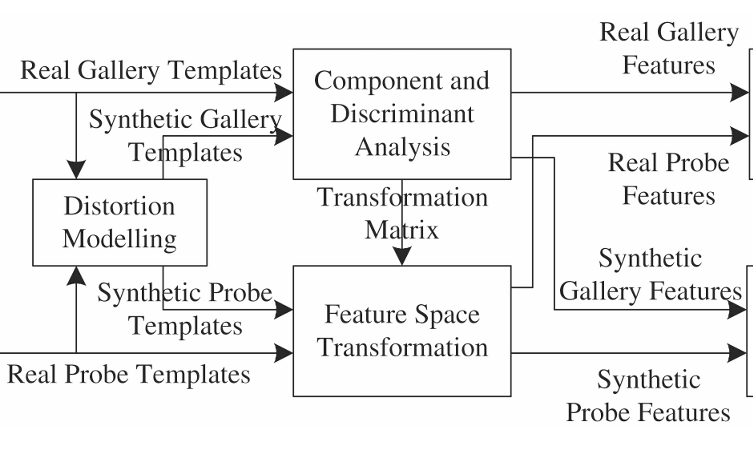

In [13]:
def extract_features(real_gallery_templ, synth_gallery_templ, real_probe_templ, synth_probe_templ):
    # input:
    # > real_gallery_templ
    # > synth_gallery_templ
    # > real_probe_templ
    # > synth_probe_templ
    # output
    # > real_gallery_feat
    # > synth_gallery_feat
    # > real_probe_feat
    # > synth_probe_feat
    
    # tạo labels cho hàm mda
    real_gallery_labels, real_probe_labels = create_labels(4, 6, token)
    synthetic_gallery_labels, synthetic_probe_labels = create_labels(32, 48, token)

    real_gallery_feat, synth_gallery_feat, real_probe_feat, synth_probe_feat = [], [], [], []
    
    return real_gallery_feat, synth_gallery_feat, real_probe_feat, synth_probe_feat

In [14]:
# # 4. Implement PCA manually

# chạy cx đc mà chưa chậm và chưa hiệu quả bằng hàm có sẵn :<
# # dữ liệu đưa vào PCA là dữ liệu 2 chiều (n x (64x64)) w. n = số lượng dữ liệu trong tập data
# def pca_transform(data, n_components):
#     # input
#     #   data 
#     #   number of components
#     # output
#     #   the transformed data
#     #   eigen vectors 
    
#     mean = np.mean(data, axis=0)
#     centered_data = data - mean
#     covariance_matrix = np.cov(centered_data, rowvar=False)
#     eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
#     sorted_indices = np.argsort(eigenvalues)[::-1]
#     eigenvectors = eigenvectors[:, sorted_indices[:n_components]]
#     transformed_data = np.dot(centered_data, eigenvectors)
#     return transformed_data, eigenvectors

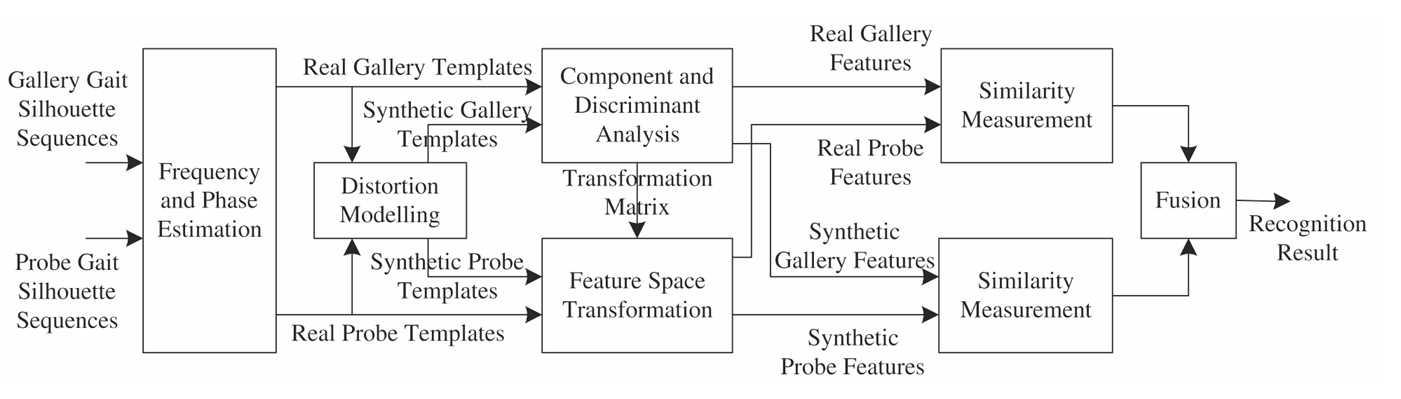

In [18]:
import os
import cv2
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as MDA
from sklearn.metrics.pairwise import euclidean_distances 

# Main
root_path = "data"
gei_path = "GEI"

if not os.path.exists(gei_path):
    os.makedirs(gei_path)  

# xử lý ảnh GEI và lưu lại về và trả về token labels cho mỗi đối tượng trong dataset
# xóa comment phần xử lý ảnh trong hàm gei_img_process nếu chưa có dữ liệu ảnh GEI hoặc thêm/bớt dữ liệu
token = gei_img_process(root_folder)

# tải data lên lại để xử lý
real_gallery, real_probe = load_data(gei_path)

# tạo thêm ảnh synthetic cho gallery và probe
synthetic_gallery = synthetic_templates(real_gallery)
synthetic_probe = synthetic_templates(real_probe)

# tạo labels để sử dụng trong hàm MDA
real_gallery_labels, real_probe_labels = create_labels(4, 6, token)
syn_gallery_labels, syn_probe_labels = create_labels(32, 48, token)

# hết cả đoạn code trên chạy tốn khoảng 1 giây, khi ko cần xử lý ảnh GEI trong gei_img_process :>

[11, 11, 11, 11, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
876
1314
7008
10512


In [16]:
# giảm chiều dữ liệu để trích xuất đặc trưng
# hàm phía dưới chạy tốn khoảng 2 phút :/
# hàm sẽ chạy nhanh hơn nếu mình cụ thể sẵn có components :)) má nó
real_gallery_pca, real_gallery_mda, syn_gallery_pca, syn_gallery_mda = pca_and_mda(real_gallery, synthetic_gallery, real_gallery_labels, synthetic_gallery_labels)

real_probe_pca, real_probe_mda, syn_probe_pca, syn_probe_mda = pca_and_mda(real_probe, synthetic_probe, real_probe_labels, syn_probe_labels)

print(real_gallery_pca.shape, real_gallery_mda.shape, syn_gallery_pca.shape, syn_gallery_mda.shape)
print(real_probe_pca.shape, real_probe_mda.shape, syn_probe_pca.shape, syn_probe_mda.shape)

(876, 100) (876, 19) (7008, 100) (7008, 19)
(1314, 100) (1314, 19) (10512, 100) (10512, 19)


In [22]:
euclid1 = euclidean_distances(real_gallery_mda, real_probe_mda)
print(euclid1.shape)

euclid2 = euclidean_distances(syn_gallery_mda, syn_probe_mda)
print(euclid2.shape)

(876, 1314)
(7008, 10512)
